# Libraries

In [1]:
# System Libraries
import os
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import Image

# Metrics and Preprocessing
import cv2
import PIL
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Configurations

In [2]:
# Check Tensorflow Version
print(tf.__version__)

2.17.0


In [3]:
#Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Data setup
DATA_DIR = r'/kaggle/input/leukemia-classification/AUGMENTED dataset/Original'
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Set batch size and other hyperparameters
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.2
EXPERIMENT_NAME = "NASNetLarge_Leukemia_Classification"

# Data Pre-Processing

- Load all training and testing data

- Dividing the dataset into Training, Testing, and Validation sets

- Normalize images with MinMax Normalization

In [4]:
# Initialize empty lists for images and labels
images = []
labels = []

# Loop through each class and preprocess images
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.exists(class_dir):
        continue
    
    for img_name in sorted(os.listdir(class_dir)):
        img_path = os.path.join(class_dir, img_name)
        
        # Use OpenCV to load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        images.append(img)
        
        # Assign label (categorical index)
        labels.append(class_idx)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [5]:
# Convert labels to categorical (one-hot encoding)
labels_categorical = tf.keras.utils.to_categorical(labels, num_classes=len(CLASSES))

# Shuffle dataset globally
images, labels_categorical = shuffle(images, labels_categorical, random_state=42)

In [6]:
# Split dataset into train+val and test sets (90% train/val, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels_categorical, test_size=0.15, shuffle=True, random_state=42
)

# Calculate the proportion for validation set from the train+val data
val_size = 0.15 / (1 - 0.15)  # Validation size relative to train+val size

# Split train+val into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42
)

In [7]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

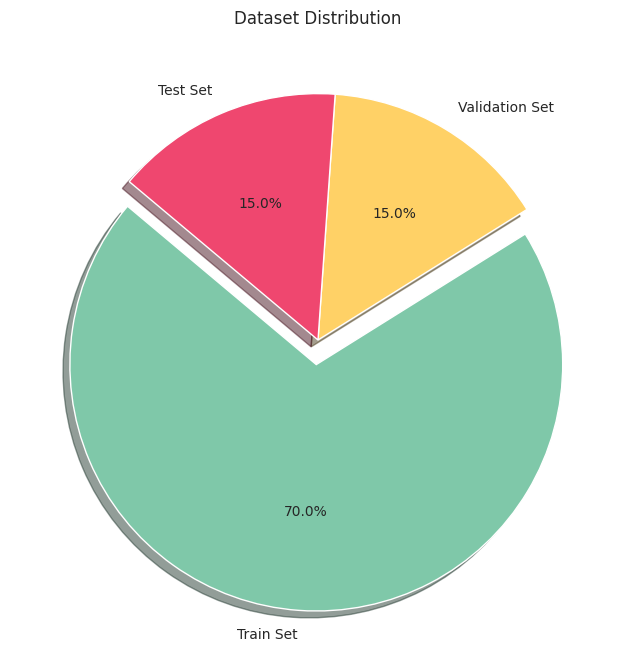

In [8]:
# Plot dataset distribution
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train Set', 'Validation Set', 'Test Set']
colors = ['#7FC8A9', '#FFD166', '#EF476F']
explode = (0.1, 0, 0)  # Explode the Train Set slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Dataset Distribution')
plt.show()

In [9]:
# Verify data information
print(f'Dataset Summary:')
print(f'TOTAL IMAGES: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')  # Total images from all sets
print(f'IMAGE SHAPE: {X_train.shape[1:]}')  # Image shape is the same for all datasets
print(f'CLASS LABELS: {CLASSES}')  # Ensure CLASSES is defined earlier
print(f'TRAIN SET: {X_train.shape[0]} images')
print(f'VALIDATION SET: {X_val.shape[0]} images')
print(f'TEST SET: {X_test.shape[0]} images')

Dataset Summary:
TOTAL IMAGES: 4000
IMAGE SHAPE: (224, 224, 3)
CLASS LABELS: ['Benign', 'Early', 'Pre', 'Pro']
TRAIN SET: 2800 images
VALIDATION SET: 600 images
TEST SET: 600 images


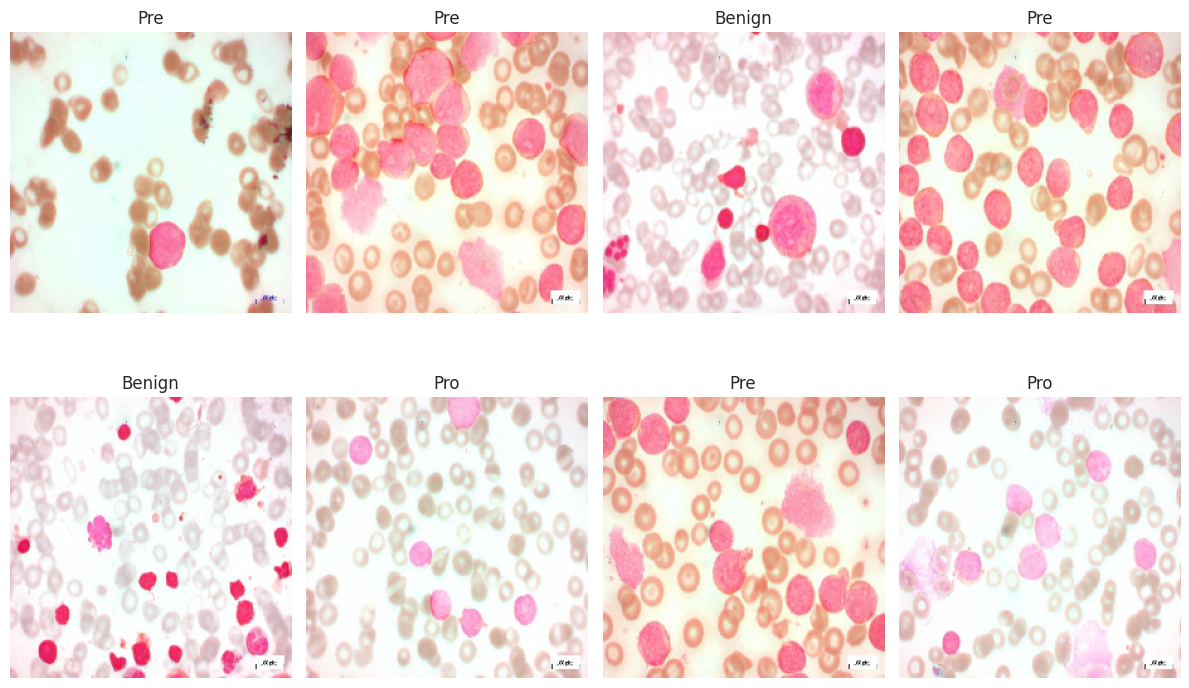

In [10]:
# Display sample images with their corresponding labels
plt.figure(figsize=(12, 8))
for i in range(8):  # Display 8 random samples
    idx = np.random.randint(len(X_train))
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[idx])
    label_idx = np.argmax(y_train[idx])  # Get class index from one-hot encoding
    plt.title(CLASSES[label_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# NASNetLarge

In [11]:
base_model = NASNetLarge(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "NASNetLarge"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ nasnet_large (Functional)            │ (None, 7, 7, 4032)          │      84,916,818 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 4032)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4032)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,032,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,950,294 (327.87 MB)

 Trainable params: 1,033,476 (3.94 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

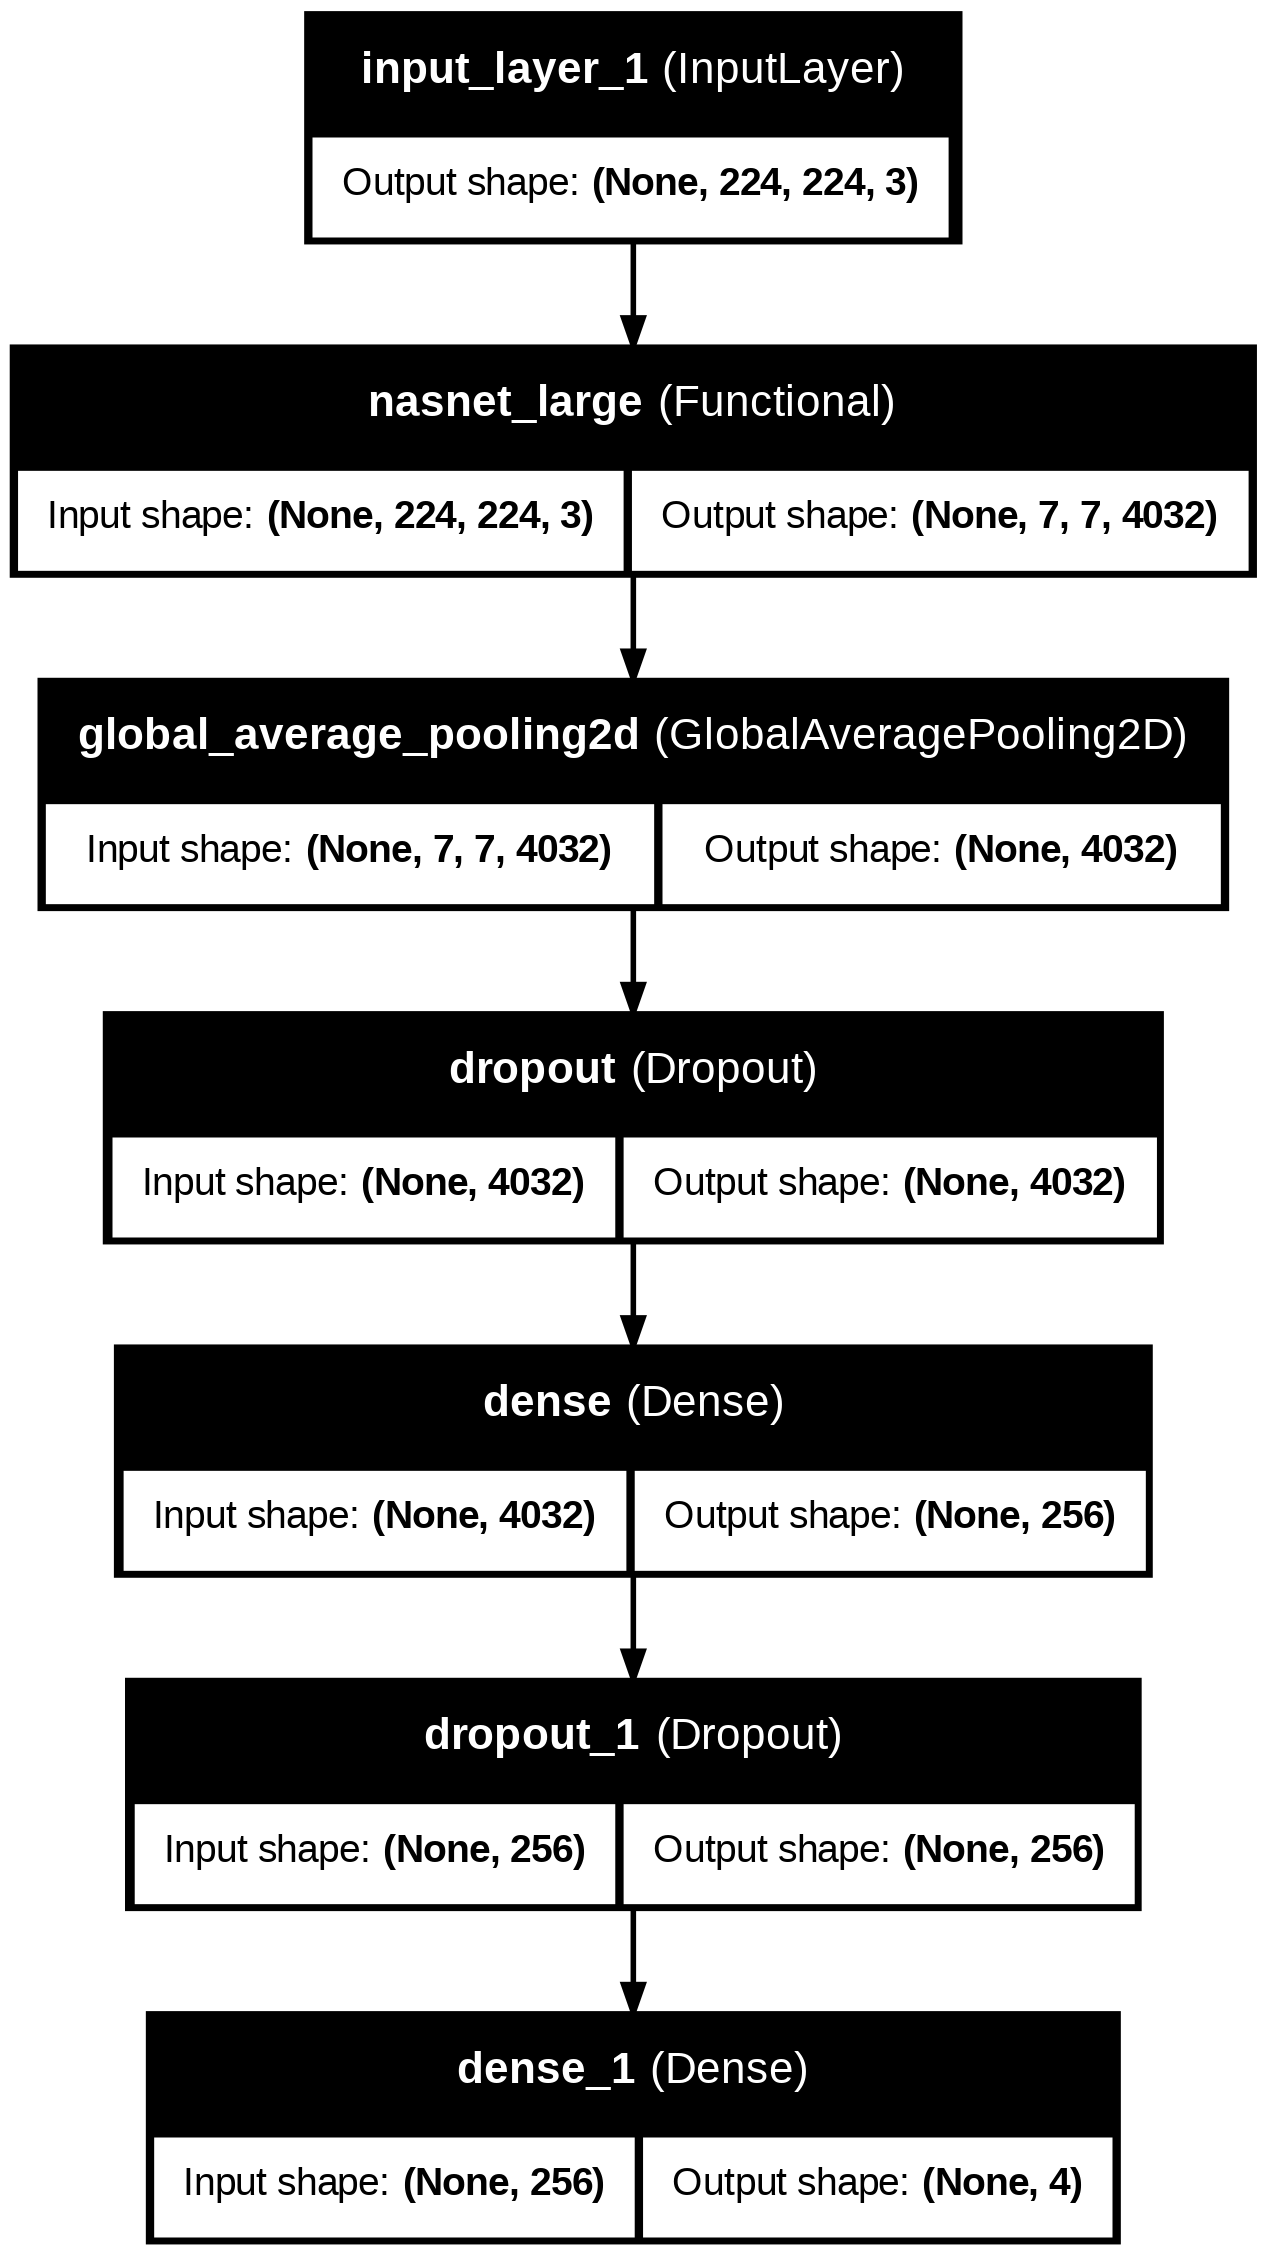

In [12]:
# Model architecture
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATE)(x)

# Additional dense layer
x = Dense(256, activation='relu')(x) 
x = Dropout(DROPOUT_RATE)(x)

# x = Dense(128, activation='relu')(x) 
# x = Dropout(DROPOUT_RATE)(x)

# Output layer
outputs = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs, outputs, name="NASNetLarge")
model.summary()

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# Compile the model with both loss and accuracy metrics
optimizer = Adam(learning_rate=LEARNING_RATE)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy']  # Add accuracy as a metric
)

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(f'{EXPERIMENT_NAME}_best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 743ms/step - accuracy: 0.6107 - loss: 0.9857 - val_accuracy: 0.8483 - val_loss: 0.4452 - learning_rate: 1.0000e-04
Epoch 2/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 268ms/step - accuracy: 0.8661 - loss: 0.4186 - val_accuracy: 0.8850 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 3/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.9091 - loss: 0.3129 - val_accuracy: 0.9083 - val_loss: 0.2706 - learning_rate: 1.0000e-04
Epoch 4/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.9250 - loss: 0.2442 - val_accuracy: 0.9233 - val_loss: 0.2330 - learning_rate: 1.0000e-04
Epoch 5/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - accuracy: 0.9344 - loss: 0.2070 - val_accuracy: 0.9350 - val_loss: 0.2120 - learning_rate: 1.0000e-04
Epoch 6/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.9427 - loss: 0.1749 - val_accuracy: 0.9383 - val_loss: 0.1966 - learning_rate: 1.0000e-04
Epoch 7/60
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - ac

# Results

In [14]:
# Make predictions on the validation dataset
predictions = model.predict(val_ds)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Convert true labels from one-hot encoding to class labels if necessary
if true_labels.ndim > 1 and true_labels.shape[1] > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=CLASSES)
print(report)


19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 976ms/step
              precision    recall  f1-score   support

      Benign       0.92      0.93      0.93       149
       Early       0.90      0.94      0.92       142
         Pre       1.00      0.97      0.99       149
         Pro       1.00      0.97      0.98       160

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.96      0.95      0.96       600



In [15]:
# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(train_ds)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_acc}")

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.9929 - loss: 0.0416
Training Loss: 0.04363557696342468
Training Accuracy: 0.9910714030265808
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9433 - loss: 0.1291
Validation Loss: 0.12953905761241913
Validation Accuracy: 0.9549999833106995
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9620 - loss: 0.1030
Test Loss: 0.12160032987594604
Test Accuracy: 0.9566666483879089


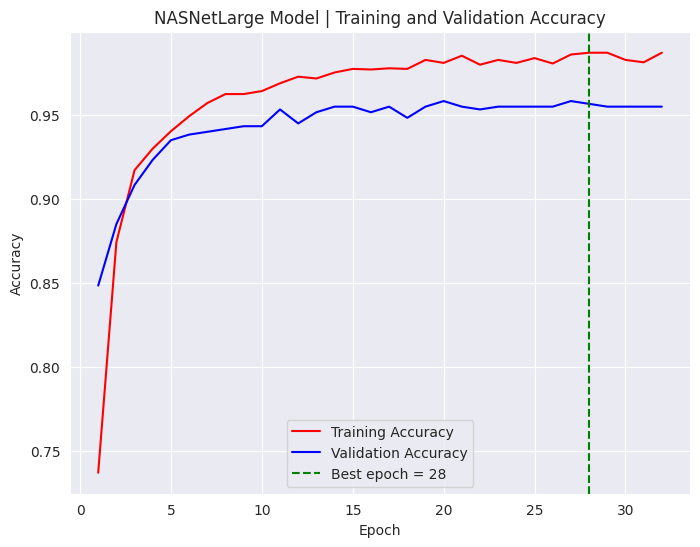

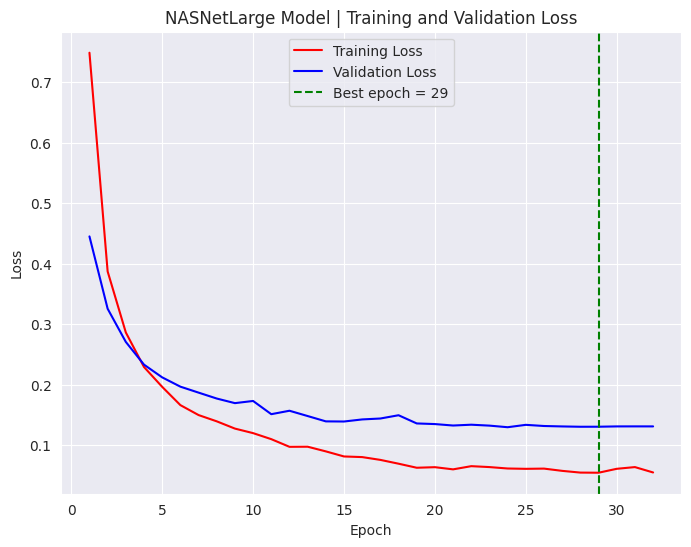

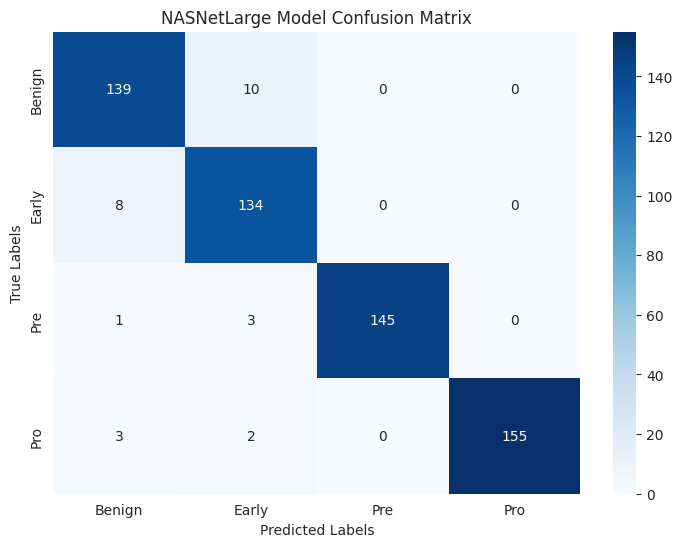

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 946ms/step


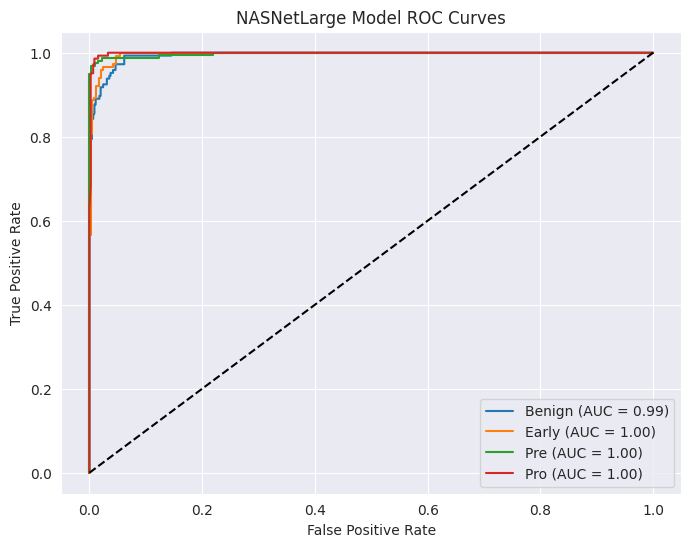

In [16]:
# Calculate best epochs
tr_acc = model_history.history['accuracy']
index_acc = np.argmax(tr_acc)  # Find epoch with highest training accuracy
index_loss = np.argmin(model_history.history['loss'])  # Find epoch with lowest training loss

# Plot accuracy and loss curves
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Accuracy plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b', label='Validation Accuracy')
plt.axvline(x=index_acc + 1, color='g', linestyle='--', label=f'Best epoch = {index_acc + 1}')
plt.title('NASNetLarge Model | Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=[8, 6])
plt.plot(Epochs, loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'b', label='Validation Loss')
plt.axvline(x=index_loss + 1, color='g', linestyle='--', label=f'Best epoch = {index_loss + 1}')
plt.title('NASNetLarge Model | Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8.5, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('NASNetLarge Model Confusion Matrix')
plt.show()

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=range(len(CLASSES)))

# Plot ROC Curves
plt.figure(figsize=(8, 6))
y_pred_proba = model.predict(X_test)
for i in range(len(CLASSES)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{CLASSES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NASNetLarge Model ROC Curves')
plt.legend()
plt.show()

# Save Model

In [17]:
model.save('NASNetLarge_model.h5')